# 2 Computer vision - Fire Detection - MLFlow - Hi! PARIS x Pyronear

Tim Luka Horstmann

tim.horstmann@ip-paris.fr

## Import relevant libraries
(Includes pip install commands for colab)

In [ ]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils import data
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision

# Math
import matplotlib.pyplot as plt
import numpy as np

# CV Model (YOLO)
!pip install ultralytics --quiet
from ultralytics import YOLO

# WANDB (Alternative to MLFlow)
!pip install wandb --quiet
import wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 870.5/870.5 kB 8.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.5/314.5 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.6 MB/s eta 0:00:00


## Test consistency in dataset
Upon analysis of the original (full) dataset, an inconsistency between the training/validation samples and their corresponding labels was identified (i.e. not all images had a corresponding label). Therefore, the code to create a subset of the original training dataset considered this inconsistency and ensured that every image in the new (smaller) dataset has a label associated to it.

The below code simply double-checks the dataset for consistency between images and labels in both the training and validation set.

In [ ]:
from pathlib import Path

def count_files(split):
    image_dir = Path('drive/MyDrive/HIParis/DS-71c1fd51-v2-small/images') / split
    label_dir = Path('drive/MyDrive/HIParis/DS-71c1fd51-v2-small/labels') / split

    # Count images & labels
    image_files = list(image_dir.glob('*.jpg'))
    label_files = list(label_dir.glob('*.txt'))

    return len(image_files), len(label_files)

# Count files in training and validation folders
train_image_count, train_label_count = count_files('train')
val_image_count, val_label_count = count_files('val')
print(f"Training images: {train_image_count}, Training labels: {train_label_count}")
print(f"Validation images: {val_image_count}, Validation labels: {val_label_count}")

# Check for consistency using the counts
# (one could check the names for higher accuracy as well but this was ensured in the split of the data)
if train_image_count == train_label_count:
    print("Training image and label counts match.")
else:
    print("Training image and label counts do not match.")

if val_image_count == val_label_count:
    print("Validation image and label counts match.")
else:
    print("Validation image and label counts do not match.")

Training images: 621, Training labels: 621
Validation images: 148, Validation labels: 148
Training image and label counts match.
Validation image and label counts match.


## Hyperparameter optimisation
Based on https://docs.ultralytics.com/guides/hyperparameter-tuning/

Note: HPO is not conducted here due to time and resource constraints. This part would be executed if I had one month to work on the project.

Apart from YOLO's "tune" function, I would most likely leverage other HPO frameworks I have worked with in the past, such as Optuna (https://optuna.org/).

In [ ]:
MODEL = 'YOLO11n'
EPOCHS = 50
model = YOLO(f'{MODEL}.pt')

# Train YOLO model
results = model.tune(
    data='drive/MyDrive/HIParis/DS-71c1fd51-v2-small/data.yaml',
    epochs=EPOCHS,
    iterations=300,
    plots=False,
    save=False,
    val=False
)

#...

## Train a YOLO model with given parameters
- Models: https://docs.ultralytics.com/models/
- Logging to wandb: https://wandb.ai/tlh45/HIParis --> provides numerous insights into the model's training process such as the model performance on the training and validation set, images, different metric curves, etc.


Note: The error in the below output field can safely be ignored as it is only related to the saving to wandb function and has since been changed in the code. For the purpose of visualizing the training process, I decided to keep the cell output despite this error and not rerun the whole training procedure.

In [ ]:
# PARAMETERS
EPOCHS = 100
BATCH_SIZE = 64
MODEL = 'YOLO11n'

# Log data to wandb
# Project can be found here: https://wandb.ai/tlh45/HIParis
wandb.login()
wandb.init(
    project='HIParis',
    name=f'exp_{EPOCHS}epochs',
    config={
        'model': MODEL,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'image_size': 640
    }
)

model = YOLO(f'{MODEL}.pt')

# Train YOLO model
results = model.train(
    data='drive/MyDrive/HIParis/DS-71c1fd51-v2-small/data.yaml',
    epochs=EPOCHS,
    imgsz=640,
    batch=BATCH_SIZE,
    device='cuda',
    project='drive/MyDrive/HIParis/runs/',
    name=f'exp_{EPOCHS}epochs',
    save_period=5,
    patience=20  # Early stopping patience (for now, set to 20)
)

# Save final model locally
model_path = f'drive/MyDrive/HIParis/yolo11n_custom_{EPOCHS}epochs.pt'
model.save(model_path)

# Create and log model as a W&B artifact
# (updated code -> saving as artifcat rather than using wandb.save())
artifact = wandb.Artifact(f'{MODEL}_custom_{EPOCHS}epochs', type='model')
artifact.add_file(model_path)
wandb.log_artifact(artifact)

wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tlh45. Use `wandb login --relogin` to force relogin


100%|██████████| 5.35M/5.35M [00:00<00:00, 94.1MB/s]


Ultralytics 8.3.14 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=drive/MyDrive/HIParis/DS-71c1fd51-v2-small/data.yaml, epochs=100, time=None, patience=30, batch=64, imgsz=640, save=True, save_period=5, cache=False, device=cuda, workers=8, project=drive/MyDrive/HIParis/runs/, name=exp_100epochs, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_

100%|██████████| 755k/755k [00:00<00:00, 21.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/HIParis/DS-71c1fd51-v2-small/labels/train.cache... 621 images, 0 backgrounds, 0 corrupt: 100%|██████████| 621/621 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/HIParis/DS-71c1fd51-v2-small/labels/val.cache... 148 images, 0 backgrounds, 0 corrupt: 100%|██████████| 148/148 [00:00<?, ?it/s]


Plotting labels to drive/MyDrive/HIParis/runs/exp_100epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to drive/MyDrive/HIParis/runs/exp_100epochs
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.76G      1.912      4.674      1.629         80        640: 100%|██████████| 10/10 [02:53<00:00, 17.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.52s/it]

                   all        148        149    0.00158       0.47    0.00171   0.000786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.76G      1.661      3.956      1.418         81        640: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all        148        149    0.00241      0.718     0.0921     0.0586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.76G      1.708      3.325      1.481        105        640: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]

                   all        148        149    0.00209      0.624     0.0461     0.0184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.76G      1.772      3.136      1.509         79        640: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]

                   all        148        149    0.00198      0.591     0.0489     0.0189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.76G      1.733      2.902      1.487         81        640: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


                   all        148        149     0.0475      0.121     0.0504     0.0194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.76G      1.783      2.778      1.491         84        640: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all        148        149       0.19     0.0604     0.0409    0.00817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.76G      1.849      2.776      1.605         88        640: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all        148        149     0.0398     0.0403     0.0119     0.0048



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.76G      1.947       2.65      1.666         89        640: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all        148        149     0.0383     0.0134    0.00567    0.00169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.76G      1.986      2.639      1.658         89        640: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

                   all        148        149     0.0336    0.00671    0.00108   0.000297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.76G      1.916      2.396      1.647        100        640: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all        148        149   0.000402     0.0738   0.000197   4.78e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.76G      1.955      2.378      1.656         78        640: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.43s/it]

                   all        148        149   0.000341      0.101   0.000187   4.77e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.76G      1.984      2.321      1.659         82        640: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]

                   all        148        149     0.0186      0.094    0.00879    0.00255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.76G      1.853      2.038      1.575        100        640: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all        148        149     0.0458      0.047     0.0121    0.00303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.76G      1.866       2.02      1.625         83        640: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all        148        149     0.0232     0.0805     0.0057    0.00204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.76G      1.893      2.024      1.613         84        640: 100%|██████████| 10/10 [00:13<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all        148        149      0.184      0.255      0.112     0.0429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.76G      1.877      1.968      1.627         89        640: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all        148        149      0.168      0.107     0.0749     0.0334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.76G      1.823      1.868      1.542         80        640: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]

                   all        148        149      0.323      0.295      0.224     0.0961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.76G      1.775      1.862      1.524         82        640: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]

                   all        148        149      0.384      0.369      0.322      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.76G       1.85      1.841      1.583         94        640: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]

                   all        148        149      0.376       0.36       0.28      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.76G      1.803      1.766      1.512         94        640: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all        148        149       0.46      0.443      0.394      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.76G      1.755      1.766      1.505         80        640: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all        148        149       0.36      0.295      0.258      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.76G      1.729      1.681      1.499         84        640: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all        148        149      0.331      0.356      0.247      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.76G      1.742      1.674        1.5         71        640: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all        148        149      0.207      0.295       0.19     0.0964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.76G      1.713      1.683      1.488        100        640: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]

                   all        148        149     0.0258      0.047    0.00567    0.00237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.76G      1.648      1.626       1.45         67        640: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]

                   all        148        149        0.4      0.322      0.282      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.76G      1.684      1.679      1.492         86        640: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]

                   all        148        149       0.37      0.356      0.252      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.76G      1.644      1.578      1.438         70        640: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all        148        149      0.502      0.409      0.409      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.76G      1.661      1.604      1.461         85        640: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]

                   all        148        149      0.654      0.354      0.375      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.76G      1.663      1.567      1.462         83        640: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all        148        149      0.632      0.396      0.465      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.76G      1.595      1.561      1.429         80        640: 100%|██████████| 10/10 [00:13<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all        148        149       0.16      0.248      0.114     0.0596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.76G      1.626      1.541      1.418         76        640: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]

                   all        148        149      0.616      0.349      0.418      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.76G       1.68       1.53      1.446         91        640: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]

                   all        148        149       0.54      0.409      0.421      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.76G      1.581      1.433      1.389         89        640: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]

                   all        148        149      0.606      0.423      0.444      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.76G      1.606      1.479      1.405         65        640: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]

                   all        148        149      0.559       0.43      0.453      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.76G      1.587      1.479      1.404         94        640: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all        148        149      0.358      0.201      0.153     0.0726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.76G      1.524      1.438      1.384         88        640: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all        148        149      0.418      0.453      0.398      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.76G      1.584      1.485      1.406         84        640: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all        148        149      0.489      0.436      0.411      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.76G      1.555      1.458      1.388         91        640: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all        148        149       0.46      0.154      0.151     0.0715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.76G      1.544      1.433      1.378         79        640: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]

                   all        148        149      0.357      0.215      0.217        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.76G        1.5      1.348      1.337         68        640: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]

                   all        148        149      0.504      0.416      0.418      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.76G      1.524      1.416      1.357         91        640: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all        148        149      0.663       0.43      0.463      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.76G      1.499      1.322      1.365         84        640: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all        148        149      0.516      0.408      0.406      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.76G      1.456      1.366      1.339         77        640: 100%|██████████| 10/10 [00:13<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all        148        149      0.381       0.43      0.348      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.76G      1.446      1.317      1.317         88        640: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all        148        149      0.204      0.242      0.116     0.0603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.76G      1.493      1.371      1.354         80        640: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

                   all        148        149      0.319      0.261      0.177     0.0907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.76G      1.438      1.304      1.299         79        640: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]

                   all        148        149      0.561      0.322      0.309      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.76G      1.419        1.3      1.317         94        640: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]

                   all        148        149      0.657       0.51      0.563      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.76G      1.452      1.297      1.303         91        640: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]

                   all        148        149       0.55      0.426      0.465      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.76G      1.433      1.235      1.307        101        640: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all        148        149      0.498       0.49      0.468       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.76G      1.455      1.237      1.307         75        640: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all        148        149      0.535      0.443      0.458      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.76G      1.406      1.228      1.313         82        640: 100%|██████████| 10/10 [00:12<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all        148        149      0.525      0.356      0.388      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.76G      1.384      1.233      1.292         93        640: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]

                   all        148        149      0.609      0.443      0.488      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.76G      1.364      1.198      1.269         87        640: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]

                   all        148        149      0.514      0.477      0.437      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.76G      1.368      1.144      1.277         91        640: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]

                   all        148        149      0.542      0.544      0.525      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.76G      1.369      1.162      1.265         75        640: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all        148        149       0.48      0.483      0.459      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.76G      1.351      1.171      1.253         83        640: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all        148        149      0.457      0.423       0.39      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      8.76G      1.346      1.157      1.246         83        640: 100%|██████████| 10/10 [00:12<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all        148        149       0.64      0.497      0.528      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.76G       1.35      1.129      1.236         74        640: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all        148        149      0.621      0.564       0.56      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.76G      1.303       1.11      1.221         99        640: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]

                   all        148        149      0.633      0.614      0.603      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.76G      1.308      1.137      1.244         90        640: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]

                   all        148        149      0.641       0.53      0.557      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      8.76G      1.267      1.091      1.204         79        640: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]

                   all        148        149      0.607      0.537       0.55      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.76G      1.302      1.137      1.225         84        640: 100%|██████████| 10/10 [00:10<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all        148        149      0.615      0.497       0.52      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      8.76G      1.325      1.153      1.236         74        640: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

                   all        148        149      0.601      0.537      0.565      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.76G        1.3      1.083      1.231         74        640: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]

                   all        148        149      0.687      0.471      0.545      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      8.76G      1.275      1.043      1.211         81        640: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all        148        149      0.671      0.355      0.398      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.76G      1.244      1.054      1.192         80        640: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]

                   all        148        149       0.51      0.399      0.382      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.76G      1.236       1.03      1.167         64        640: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]

                   all        148        149      0.565      0.477      0.516      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.76G      1.284      1.072      1.202         79        640: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]

                   all        148        149      0.619      0.584      0.605      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.76G      1.197      1.005      1.187         84        640: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]

                   all        148        149      0.766      0.537      0.632      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.76G      1.248      1.034      1.197         72        640: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all        148        149      0.615      0.383      0.431      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.76G       1.22      1.021      1.176         86        640: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all        148        149      0.622      0.463      0.466      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.76G      1.195     0.9712      1.151         69        640: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all        148        149      0.586      0.561      0.589      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.76G      1.209     0.9987      1.176         76        640: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]

                   all        148        149      0.697      0.509      0.584      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.76G      1.218      1.005      1.173         81        640: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]

                   all        148        149      0.625      0.503      0.577      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.76G      1.219     0.9555      1.169         71        640: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

                   all        148        149      0.644      0.617      0.649      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.76G      1.174     0.9479      1.152         78        640: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]

                   all        148        149      0.682      0.564      0.619      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.76G       1.18     0.9498       1.15         93        640: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all        148        149      0.662      0.619      0.655      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.76G      1.178     0.9479       1.14         68        640: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all        148        149      0.653      0.577      0.615      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      8.76G       1.15     0.9644      1.156         75        640: 100%|██████████| 10/10 [00:13<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all        148        149       0.67      0.483      0.533      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.76G       1.15      0.943      1.138         88        640: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        148        149      0.672      0.523      0.572      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.76G       1.15     0.9101      1.133         90        640: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]

                   all        148        149      0.692      0.591      0.647      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.76G      1.121     0.8998      1.133         84        640: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]

                   all        148        149      0.785      0.597      0.655       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.76G      1.118     0.9171      1.122         71        640: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]

                   all        148        149      0.721      0.577      0.646      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.76G      1.092     0.8837      1.127         96        640: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all        148        149      0.728       0.61      0.598      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.76G       1.09     0.8723      1.105         88        640: 100%|██████████| 10/10 [00:13<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all        148        149      0.716       0.51      0.567      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.76G      1.112     0.9084      1.135         79        640: 100%|██████████| 10/10 [00:12<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]

                   all        148        149      0.763      0.591      0.638      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.76G      1.059     0.8305      1.098         73        640: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]

                   all        148        149      0.749      0.584      0.633      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.76G      1.107     0.8632      1.119         82        640: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]

                   all        148        149      0.679      0.581      0.613      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      8.76G      1.072     0.8655      1.096         89        640: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]

                   all        148        149      0.747      0.554      0.619      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.76G      1.077     0.8428       1.09         96        640: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all        148        149      0.742      0.557      0.622       0.34


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.76G      1.107      0.901      1.104         45        640: 100%|██████████| 10/10 [00:23<00:00,  2.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

                   all        148        149      0.782      0.517      0.587      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.76G      1.059     0.7956      1.067         42        640: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

                   all        148        149      0.637      0.611      0.596      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.76G      1.032     0.7603      1.073         46        640: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]

                   all        148        149      0.658      0.617      0.623      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      8.76G      1.039     0.7744      1.058         46        640: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]

                   all        148        149      0.703      0.584       0.63       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.76G      1.036     0.7942      1.059         44        640: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all        148        149      0.757       0.55      0.625      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.76G      1.006     0.7508      1.042         45        640: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all        148        149      0.767      0.577      0.655      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.76G       1.01     0.7507      1.042         42        640: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all        148        149       0.68      0.631      0.665      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.76G     0.9746     0.7525       1.04         46        640: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]

                   all        148        149      0.729      0.624      0.672      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.76G      1.025     0.7437      1.048         45        640: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]

                   all        148        149      0.748      0.618      0.661      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.76G      0.971     0.7124      1.039         45        640: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]

                   all        148        149      0.717      0.647      0.666      0.382



100 epochs completed in 0.508 hours.
Optimizer stripped from drive/MyDrive/HIParis/runs/exp_100epochs/weights/last.pt, 5.5MB
Optimizer stripped from drive/MyDrive/HIParis/runs/exp_100epochs/weights/best.pt, 5.5MB

Validating drive/MyDrive/HIParis/runs/exp_100epochs/weights/best.pt...
Ultralytics 8.3.14 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


                   all        148        149      0.689      0.631      0.665      0.385
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to drive/MyDrive/HIParis/runs/exp_100epochs


lr/pg0,▁▃▄▄▅███▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▂▂▂▂▂▁▁
lr/pg1,▂▃▄▇▇█████▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁
lr/pg2,▄▄▅▇███▇▇▇▇▇▇▇▆▆▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁
metrics/mAP50(B),▁▂▁▂▂▁▁▁▁▁▄▄▃▅▆▆▅▃▅▆▅▇▆▆▅▆▇▇▇▅▇█▇██▇▇▇▇█
metrics/mAP50-95(B),▁▁▁▁▁▁▁▁▂▃▃▅▅▅▅▅▂▄▆▅▄▅▆▇▆▆▅▇▅▆█▇█▇█▇▇███
metrics/precision(B),▁▁▁▁▁▁▁▄▄▅▄▇▂▆▄▅▅▇▄▆▆▆▆▅▇▇▇▇▆█▇▇▇█▇███▇▇
metrics/recall(B),▆██▂▁▁▂▂▅▆▅▅▆▅▅▆▃▆▆▆▅▆▅▆▇▆▇▇█▇▆▇▇███▇▇▇█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▆▆▇▇██▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁


Error: You must call wandb.init() before wandb.save()

#### Load a trained model

- used to load a model in case no training was conducted beforehand

-> (here from drive location the model was saved in before)

In [ ]:
model = YOLO(f'drive/MyDrive/HIParis/yolo11n_custom_100epochs.pt')

### Run Inference on a single image to see output
The cell below uses the trained/loaded model to predict smoke and its location for a given (randomly chosen) image from the validation dataset.

This code was written as a simple test of the model capabilities and correct training regime without evaluating the model performance quantitatively.

In [ ]:
results = model.predict('/content/drive/MyDrive/HIParis/DS-71c1fd51-v2-small/images/val/vid_0047_frame_001320.jpg')

for result in results:
  result.show()

### Evaluate Model on Validation Data:

In [ ]:
import glob # for easy paths below

# Initialize W&B logging
# (will be simplistic as yolo is only fully integrated into wandb for training)
wandb.init(project='HIParis', name='validation_run')

results = model.val(
    data='drive/MyDrive/HIParis/DS-71c1fd51-v2-small/data.yaml',
    imgsz=640,
    batch=64,
    device='cuda',
    plots=True,
    save_json=True
)

wandb.log({
    'precision': results.box.mp,
    'recall': results.box.mr,
    'map50': results.box.map50,
    'map50_95': results.box.map
})

image_paths = glob.glob('runs/detect/val/*.jpg')
wandb.log({'validation_images': [wandb.Image(img_path) for img_path in image_paths]})

print('Validation Results:')
print(results)

wandb.finish()

Ultralytics 8.3.15 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/drive/MyDrive/HIParis/DS-71c1fd51-v2-small/labels/val.cache... 148 images, 0 backgrounds, 0 corrupt: 100%|██████████| 148/148 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


                   all        148        149      0.689      0.631      0.659      0.385
Speed: 5.9ms preprocess, 3.3ms inference, 0.0ms loss, 2.3ms postprocess per image
Saving runs/detect/val/predictions.json...
Results saved to runs/detect/val


Validation Results:
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7940175eba60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,


map50,▁
map50_95,▁
precision,▁
recall,▁
map50,0.65906
map50_95,0.38462
precision,0.68909
recall,0.63087


### Model Explainability:

Employing CAM (class activation mapping) helps significantly in understanding the model's behavior. In the below image, for example, the implemented explainability functionality sheds light on which parts of the image the model considered relevant to identify smoke.
The CAM output for the 21st layer of the model (i.e. one of the last layers) makes sense and shows that the model places significant importance on the part of the image the contains the actual smoke. This means that the model is learning the correct features.

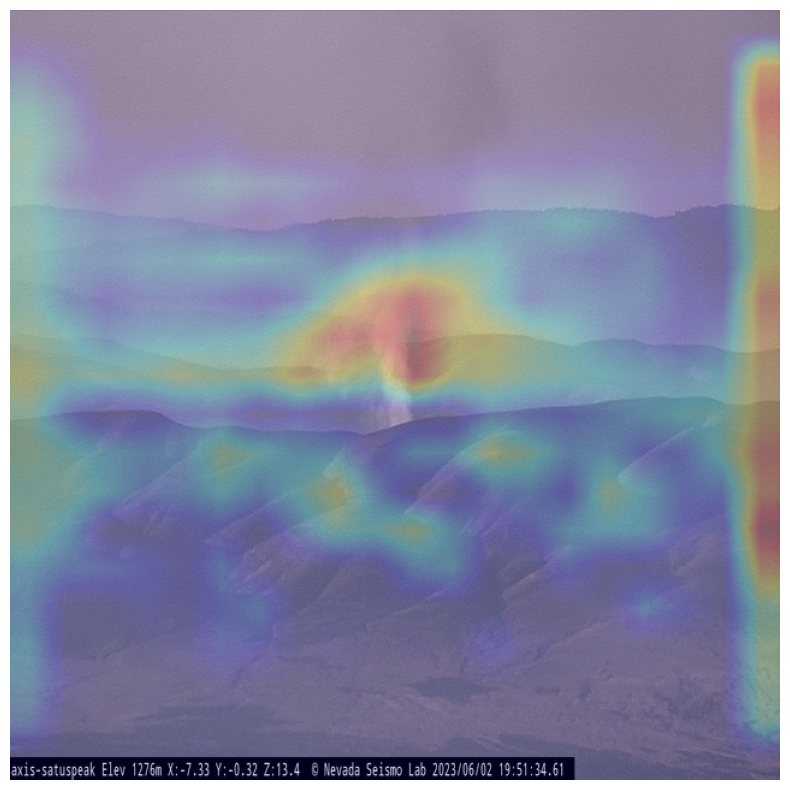

In [ ]:
# Import necessary libraries fro explainability
!pip install grad-cam --quiet
from PIL import Image
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Set model to eval mode
model.model.eval()

# Used following line to inspect model and experiment with different traget layers for explainability
# print(model.model.model)

######## SET LAYER ########
target_layer = model.model.model[21]
###########################

# Create a wrapper model to extract features
class YOLOWithActivations(torch.nn.Module):
    def __init__(self, model, target_layer):
        super(YOLOWithActivations, self).__init__()
        self.model = model.model
        self.target_layer = target_layer
        self.activations = None

        # Register forward hook to get activations from target layer
        def get_activation(module, input, output):
            if isinstance(output, (tuple, list)):
                self.activations = output[0]  # Extract first tensor (sometimes received tuple or list)
            else:
                self.activations = output

        self.target_layer.register_forward_hook(get_activation)

    def forward(self, x):
        outputs = self.model(x)
        if isinstance(outputs, (tuple, list)):
            outputs = outputs[0]  # see above
        return outputs

# Wrap model
wrapped_model = YOLOWithActivations(model, target_layer)

# Load and preprocess image
image_path = 'drive/MyDrive/HIParis/DS-71c1fd51-v2-small/images/val/AWF_axis-satuspeak_2023_06_02T19_48_07.jpg'
image = Image.open(image_path).convert('RGB')

transform = Compose([
    Resize((640, 640)),  # Resize to model's expected input size
    ToTensor()
])
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
wrapped_model.to(device)

# Initialize EigenCAM with wrapped model and target layer defined above
cam = EigenCAM(model=wrapped_model, target_layers=[target_layer])

# Generate CAM (Class activation mapping)
with torch.no_grad():
    outputs = wrapped_model(input_tensor)

    grayscale_cam = cam(input_tensor=input_tensor, targets=[])
    grayscale_cam = grayscale_cam[0, :]  # Remove batch dimension

# Convert image to NumPy array and normalize
image_np = np.array(image.resize((640, 640))).astype(np.float32) / 255.0

# Visualize CAM overlayed
visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True, image_weight=0.8)

plt.figure(figsize=(10, 10))
plt.imshow(visualization)
plt.axis('off')
plt.show()